# STAT3009 - Project 1

Team members:
* Zhu Jiaying - 1155124499
* Wang Dingdong - 1155124289
* Xu Yuhan - 1155124360

Contribution:
* Zhu Jiaying: EDA + Global+item+user_mean_LFM
* Wang Dingdong: EDA + Item+user_mean_LFM
* Xu Yuhan: Baseline Model + Smooth LFM
* Remaining part: all

---

## Contents

1. [Load and data preprocessing](#1.Load-and-data-preprocessing)
2. [Exploratory data analysis (EDA)](#2.Exploratory-data-analysis-(EDA))
3. [Model Building](#3.Model-Building)

   3.1. [Smooth LFM](#3.1.Smooth-LFM)
   
   3.2. [Baseline model: LFM](#3.2.Baseline-model:-LFM)

   3.3. [Global+item+user_mean_LFM](#3.3.Global+item+user_mean_LFM)

   3.4. [Final Model: Item+user_mean_LFM](#3.4.Final-Model:-Item+user_mean_LFM)
4. [Result](#4.Result)
5. [Conclusion](#5.Conclusion)



# 1.Load and data preprocessing

- transform the data format
- check the `user_id` and `item_id`: mapping `item_id` to a continuous sequence based on `sklean.preprocessing`
- use `sklearn.model_selection.train_test_split` to generate `train` and `test` dataset
- create `train_pair`,`train_rating`, `test_pair`

In [1]:
import numpy as np
import pandas as pd

dtrain = pd.read_csv('./train.csv')
dtest = pd.read_csv('./test.csv')
sub = pd.read_csv('./sample_submission.csv')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
## mapping 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df = dtrain.append(pd.DataFrame(data = dtest), ignore_index=True)
df['item_id'] = le.fit_transform(df['item_id'])
df['user_id'] = le.fit_transform(df['user_id'])

In [4]:
dtrain = df.iloc[:15303,:]
dtest = df.iloc[15303:,:]
dtest = dtest.drop(columns='rating')

In [5]:
# tran_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values
# test_pair
test_pair = dtest[['user_id', 'item_id']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

# 2.Exploratory data analysis (EDA)

From the graph we can see that most of users rated 5 for the items, and the distribution of data at rating=15 is strange, and we find that there are some weired users who rated many items only as 15.

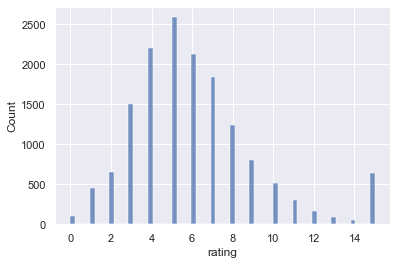

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
## histograms of rating 
sns.histplot(data=dtrain, x="rating")
plt.show()

In [7]:
#Shape of the train data
dtrain.shape

(15303, 3)

In [8]:
#Shape of the test data
dtest.shape

(3826, 2)

In [9]:
#Check the datatypes after transforming
dtrain.dtypes

user_id      int64
item_id      int64
rating     float64
dtype: object

In [10]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15303 entries, 0 to 15302
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  15303 non-null  int64  
 1   item_id  15303 non-null  int64  
 2   rating   15303 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 358.8 KB


In [11]:
#Five point summary 
dtrain.describe()['rating'].T

count    15303.000000
mean         6.065412
std          3.090915
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max         15.000000
Name: rating, dtype: float64

In [12]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(dtrain.rating.min()))
print('Maximum rating is: %d' %(dtrain.rating.max()))

Minimum rating is: 0
Maximum rating is: 15


In [13]:
#Check for missing values
print('Number of missing values across columns: \n',dtrain.isnull().sum())

Number of missing values across columns: 
 user_id    0
item_id    0
rating     0
dtype: int64


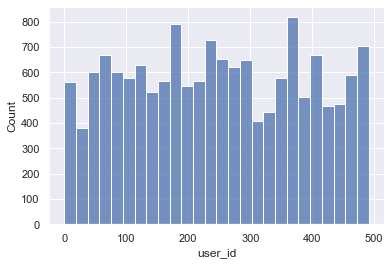

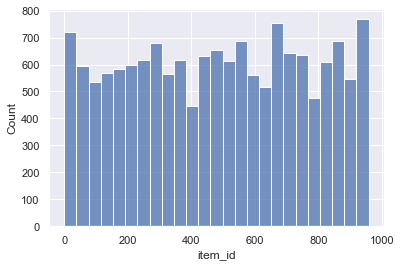

In [14]:
## histograms of user 
sns.histplot(data=dtrain, x="user_id")
plt.show()
## histograms of item 
sns.histplot(data=dtrain, x="item_id")
plt.show()

In [15]:
# Unique Users and products
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",dtrain.shape[0])
print("Total No of Users   :", len(np.unique(dtrain.user_id)))
print("Total No of products  :", len(np.unique(dtrain.item_id)))

Total data 
--------------------------------------------------

Total no of ratings : 15303
Total No of Users   : 491
Total No of products  : 950


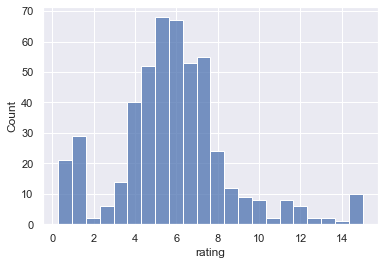

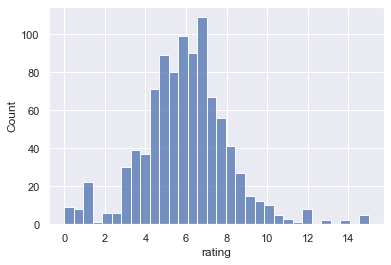

In [16]:
# histgrams for averaged ratings for users/items
sns.histplot(dtrain.groupby('user_id')['rating'].mean())
plt.show()
sns.histplot(dtrain.groupby('item_id')['rating'].mean())
plt.show()

In [17]:
## Find Top-20 highest rating items 
dtrain.groupby('item_id')['rating'].mean().sort_values(ascending = False)[:20]

item_id
403    15.000000
64     15.000000
580    15.000000
629    15.000000
252    15.000000
4      14.000000
117    14.000000
491    13.000000
102    13.000000
574    12.000000
943    12.000000
936    12.000000
761    12.000000
65     12.000000
310    12.000000
653    12.000000
681    11.875000
787    11.571429
299    11.200000
647    11.000000
Name: rating, dtype: float64

In [18]:
## Find Top-20 highest rating users 
dtrain.groupby('user_id')['rating'].mean().sort_values(ascending = False)[:20]

user_id
153    15.000000
236    15.000000
2      15.000000
357    15.000000
44     15.000000
450    15.000000
295    15.000000
193    15.000000
361    15.000000
456    14.666667
248    14.000000
75     13.000000
154    13.000000
480    12.500000
417    12.333333
431    12.000000
138    12.000000
156    12.000000
291    12.000000
185    12.000000
Name: rating, dtype: float64

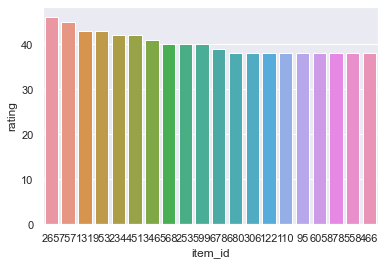

In [19]:
## Find Top-20 most popular items
dtmp = dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20]
sns.barplot(x=dtmp.index, y=dtmp, order=dtmp.index)
plt.show()

In [25]:
## Find Top-20 users who rate most items
dtrain.groupby('user_id')['rating'].count().sort_values(ascending = False)[:20]

user_id
357    86
295    84
2      80
193    79
450    79
208    78
252    78
70     77
104    76
491    75
214    74
146    74
361    74
303    74
236    73
259    73
394    73
153    72
226    72
50     72
Name: rating, dtype: int64

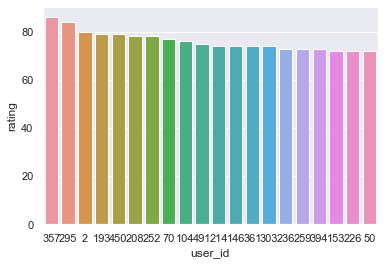

In [20]:
## Find Top-20 users who rate most items
dtmp = dtrain.groupby('user_id')['rating'].count().sort_values(ascending = False)[:20]
sns.barplot(x=dtmp.index, y=dtmp, order=dtmp.index)
plt.show()

In [21]:
#Analysis of rating given by the user 
no_of_rated_products_per_user = dtrain.groupby(by='user_id')['rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

user_id
357    86
295    84
2      80
193    79
450    79
Name: rating, dtype: int64

In [22]:
no_of_rated_products_per_user.describe()

count    491.000000
mean      31.167006
std       22.902290
min        1.000000
25%        9.000000
50%       28.000000
75%       51.000000
max       86.000000
Name: rating, dtype: float64

In [23]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

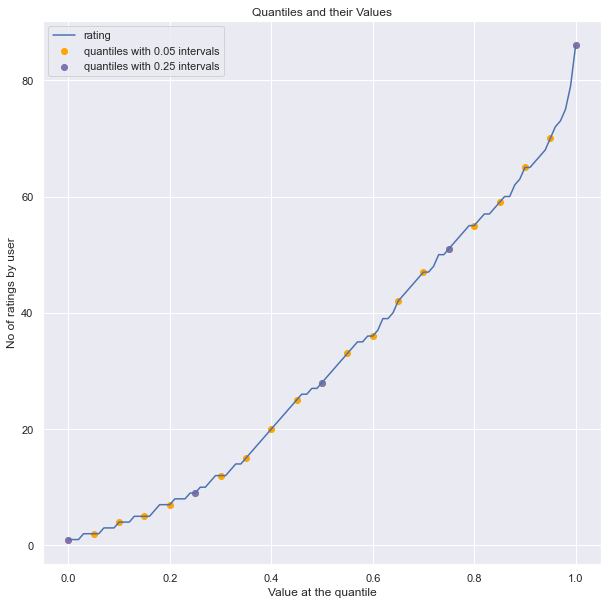

In [24]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

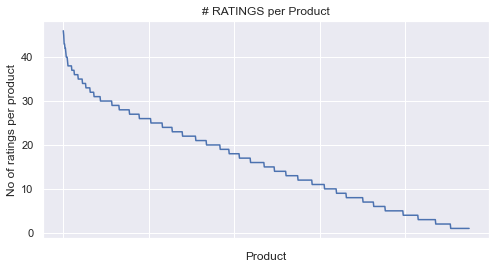

In [26]:
no_of_ratings_per_product = dtrain.groupby(by='item_id')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [27]:
#Average rating of the product 
dtrain.groupby('item_id')['rating'].mean().head()

item_id
0     6.466667
1     6.608696
2     8.666667
3     7.562500
4    14.000000
Name: rating, dtype: float64

In [28]:
#Total no of rating for product
dtrain.groupby('item_id')['rating'].count().sort_values(ascending=False).head()

item_id
265    46
757    45
131    43
953    43
234    42
Name: rating, dtype: int64

Find new users and items in test dataset to identify whether there is a cold start problem

In [29]:
# if there exists cold start issue
total_train_user = train_pair[:,0]
total_train_item = train_pair[:,1]
total_test_user = test_pair[:,0]
total_test_item = test_pair[:,1]

train_user_set = set(total_train_user)
test_user_set = set(total_test_user)
same_user = train_user_set & test_user_set
new_user = same_user^test_user_set 
new_user
# new user = 427

train_item_set = set(total_train_item)
test_item_set = set(total_test_item)
same_item = train_item_set & test_item_set
new_item = same_item^test_item_set 
new_item
# new item = {107, 127, 317, 404, 632, 649, 752, 846, 910}

index_new_user = [np.where(test_pair[:,0]==427)[0]]
index_new_user
# [1142, 3651]
index_new_item = [np.where(test_pair[:,1]==i)[0] for i in new_item]
index_new_item
# [1741, 1307, 2233, 2312, 2249, 3373, 2253, 993, 2674]


[array([1741]),
 array([1307]),
 array([2233]),
 array([2312]),
 array([2249]),
 array([3373]),
 array([2253]),
 array([993]),
 array([2674])]

Find users who only rate for one score

In [30]:
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)] 

fixed_user=[]
fixed_rating=[]
count=0
for i in range(len(index_user)):
    index_user_tmp = index_user[i]
    if len(index_user_tmp)==0:
        print('user %d does not rate any item' %i)
    else:
         if (max(train_rating[index_user_tmp])-min(train_rating[index_user_tmp]))==0:
                count=count+1
                fixed_user.append(i)
                fixed_rating.append(max(train_rating[index_user_tmp]))
                print('user %d only rate for point %.1f' %(i, max(train_rating[index_user_tmp])))
print(count)

user 2 only rate for point 15.0
user 24 only rate for point 5.0
user 25 only rate for point 1.0
user 44 only rate for point 15.0
user 61 only rate for point 1.0
user 80 only rate for point 1.0
user 125 only rate for point 11.0
user 138 only rate for point 12.0
user 153 only rate for point 15.0
user 154 only rate for point 13.0
user 181 only rate for point 5.0
user 193 only rate for point 15.0
user 201 only rate for point 3.0
user 202 only rate for point 5.0
user 236 only rate for point 15.0
user 238 only rate for point 11.0
user 244 only rate for point 1.0
user 248 only rate for point 14.0
user 292 only rate for point 8.0
user 295 only rate for point 15.0
user 310 only rate for point 1.0
user 328 only rate for point 4.0
user 357 only rate for point 15.0
user 361 only rate for point 15.0
user 389 only rate for point 8.0
user 399 only rate for point 5.0
user 427 does not rate any item
user 444 only rate for point 7.0
user 450 only rate for point 15.0
user 460 only rate for point 5.0
user

Delete the users who only rate for 15

In [31]:
## Filtrate bad users and get new train data

bad_user=[] # the bad users
for i in range(len(index_user)):
    index_user_tmp = index_user[i]
    if len(index_user_tmp)==0:
        print('user %d does not rate any item' %i)
    else:
         if max(train_rating[index_user_tmp])==15 and min(train_rating[index_user_tmp])==15:
                bad_user.append(i) 
                item_num = len(index_item[i])
                print('user %d rate %d items and all of them are rated as 15' %(i, item_num))
bad_user

bad_index=[] 
for i in range(len(bad_user)):
    user_ind = bad_user[i]
    user_index_tmp = index_user[user_ind]
    for j in range(len(user_index_tmp)):
        bad_index.append(user_index_tmp[j])
bad_index
len(bad_index) # delete 628 lines

train_pair = np.delete(train_pair, bad_index, axis=0)
train_rating = np.delete(train_rating, bad_index, axis=0)
len(train_pair) # 14675 train lines remains


user 2 rate 12 items and all of them are rated as 15
user 44 rate 11 items and all of them are rated as 15
user 153 rate 15 items and all of them are rated as 15
user 193 rate 31 items and all of them are rated as 15
user 236 rate 10 items and all of them are rated as 15
user 295 rate 23 items and all of them are rated as 15
user 357 rate 21 items and all of them are rated as 15
user 361 rate 22 items and all of them are rated as 15
user 427 does not rate any item
user 450 rate 10 items and all of them are rated as 15


14675

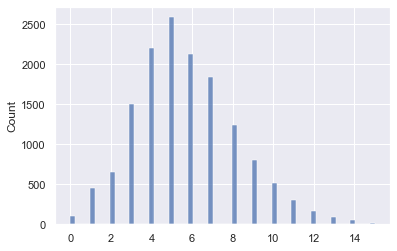

In [32]:
sns.set_theme()
## histograms of rating 
sns.histplot(data=train_rating)
plt.show()

# 3.Model Building

First we may load the developed baseline methods.

In [33]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_rating):
		self.glb_mean = np.mean(train_rating)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred
 
class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


In [69]:
# LFM (ALS)
class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=50, tol=1e-4, verbose=1):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                # find all records from `item_id`
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    # if there is no record for `item_id`, set q_i = 0.
                    self.Q[item_id,:] = 0.
                    continue
                # compute the \sum p_u p_u^T and \sum r_{ui} p_u
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                # compute the q_i as a LSE
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

## 3.1.Smooth LFM

Since there are some new user and new item that we have no historical ratings in the test set, we tried `sLFM` and used some side information generated from quantiles of the ratings grouped by both user and item according to [notebook6.ipynb](https://github.com/statmlben/CUHK-STAT3009/blob/main/notebook6.ipynb). 

In this method, we have hyperparameters $K,\lambda,$ and  `top`. Our model is `glb + (user + item)/2 + sLFM`.

In [34]:
# baseline
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
# item_mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)

train_rating_res = train_rating_cm - (user_ave.predict(train_pair) + item_ave.predict(train_pair))/2

pred = pred + (user_ave.predict(test_pair) + item_ave.predict(test_pair))/2

In [35]:
from sklearn.preprocessing import StandardScaler

user_info = pd.DataFrame({'user_id': list(range(n_user))})
user_info = user_info.set_index('user_id')
user_info['mean'] = dtrain.groupby('user_id')['rating'].mean()
user_info['q1'] = dtrain.groupby('user_id')['rating'].quantile(.1)
user_info['q3'] = dtrain.groupby('user_id')['rating'].quantile(.3)
user_info['q5'] = dtrain.groupby('user_id')['rating'].quantile(.5)
user_info['q7'] = dtrain.groupby('user_id')['rating'].quantile(.7)
user_info['q9'] = dtrain.groupby('user_id')['rating'].quantile(.9)
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)

movie_info = pd.DataFrame({'item_id': list(range(n_item))})
movie_info = movie_info.set_index('item_id')
movie_info['mean'] = dtrain.groupby('item_id')['rating'].mean()
movie_info['q1'] = dtrain.groupby('item_id')['rating'].quantile(.1)
movie_info['q3'] = dtrain.groupby('item_id')['rating'].quantile(.3)
movie_info['q5'] = dtrain.groupby('item_id')['rating'].quantile(.5)
movie_info['q7'] = dtrain.groupby('item_id')['rating'].quantile(.7)
movie_info['q9'] = dtrain.groupby('item_id')['rating'].quantile(.9)
## fill NAN as the column mean
movie_info = movie_info.fillna(movie_info.mean())
movie_scaler = StandardScaler()
movie_info = movie_scaler.fit_transform(movie_info)

Weight matrix

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(user_info)
movie_sim = cosine_similarity(movie_info)

Compute the augmented dataset (use `top` = 5)

In [37]:
top = 5
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	### find the top closest users for the user u
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	### extend the records' index for the users
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	### find observed items under top users
	obs_movie_tmp = train_pair[valid_user_ind,1]
	for i in range(n_item):
		### find top items 
		top_movie_tmp = movie_sim[i].argsort()[-top:][::-1]
		### find valid item: intersect with top-items and observed item
		valid_movie_tmp = np.intersect1d(top_movie_tmp, obs_movie_tmp)
		if len(valid_movie_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_movie_tmp:
			### extend all rating index for valid item
			valid_item_ind.extend(index_item[i_tmp])
		### find index close to (u,i)
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2
UserId: 3
UserId: 4
UserId: 5
UserId: 6
UserId: 7
UserId: 8
UserId: 9
UserId: 10
UserId: 11
UserId: 12
UserId: 13
UserId: 14
UserId: 15
UserId: 16
UserId: 17
UserId: 18
UserId: 19
UserId: 20
UserId: 21
UserId: 22
UserId: 23
UserId: 24
UserId: 25
UserId: 26
UserId: 27
UserId: 28
UserId: 29
UserId: 30
UserId: 31
UserId: 32
UserId: 33
UserId: 34
UserId: 35
UserId: 36
UserId: 37
UserId: 38
UserId: 39
UserId: 40
UserId: 41
UserId: 42
UserId: 43
UserId: 44
UserId: 45
UserId: 46
UserId: 47
UserId: 48
UserId: 49
UserId: 50
UserId: 51
UserId: 52
UserId: 53
UserId: 54
UserId: 55
UserId: 56
UserId: 57
UserId: 58
UserId: 59
UserId: 60
UserId: 61
UserId: 62
UserId: 63
UserId: 64
UserId: 65
UserId: 66
UserId: 67
UserId: 68
UserId: 69
UserId: 70
UserId: 71
UserId: 72
UserId: 73
UserId: 74
UserId: 75
UserId: 76
UserId: 77
UserId: 78
UserId: 79
UserId: 80
UserId: 81
UserId: 82
UserId: 83
UserId: 84
UserId: 85
UserId: 86
UserId: 87
UserId: 88
UserId: 89
UserId: 90
UserId: 9

We use 3-fold CV to find the best $K$, $\lambda$ to fit the `LFM` model with augmentated dataset.
(since it will spent much time to run the cross-validation for the smooth model, here we just pick k=15 which is based on our historical best k result that we found it previously).

5-Fold CV for K: 15; lam: 0.00010: train_rmse: 0.767, valid_rmse: 0.839
5-Fold CV for K: 15; lam: 0.00010: train_rmse: 0.767, valid_rmse: 0.845
5-Fold CV for K: 15; lam: 0.00010: train_rmse: 0.769, valid_rmse: 0.841
5-Fold CV for K: 15; lam: 0.00010: train_rmse: 0.767, valid_rmse: 0.844
5-Fold CV for K: 15; lam: 0.00010: train_rmse: 0.769, valid_rmse: 0.835
5-Fold CV for K: 15; lam: 0.00032: train_rmse: 1.017, valid_rmse: 1.039
5-Fold CV for K: 15; lam: 0.00032: train_rmse: 1.016, valid_rmse: 1.038
5-Fold CV for K: 15; lam: 0.00032: train_rmse: 1.018, valid_rmse: 1.040
5-Fold CV for K: 15; lam: 0.00032: train_rmse: 1.017, valid_rmse: 1.033
5-Fold CV for K: 15; lam: 0.00032: train_rmse: 1.016, valid_rmse: 1.035


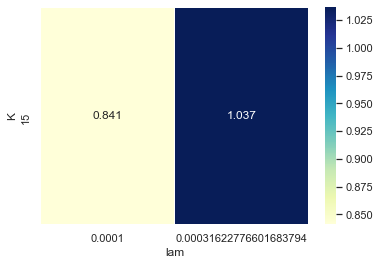

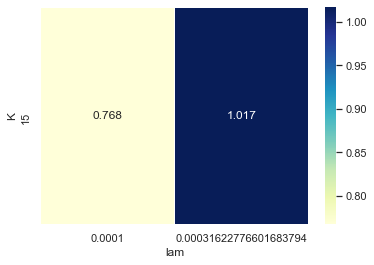

In [44]:
aug_pair, aug_rating_res = np.vstack((train_pair, fake_pair)), np.hstack((train_rating_res, fake_rating))

## fit the LFM model with augmentated dataset
Ks =[15]
lams = 10**np.arange(-5, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

In [45]:
## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
print('best K: %d, best lam: %.5f' %(best_K, best_lam))
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(aug_pair, aug_rating_res)
pred_rating = pred + shiing.predict(test_pair)

best K: 15, best lam: 0.00010
Fitting Reg-LFM: K: 15, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.679 RMSE: 1.348
Reg-LFM: ite: 1; diff: 0.367 RMSE: 0.854
Reg-LFM: ite: 2; diff: 0.054 RMSE: 0.808
Reg-LFM: ite: 3; diff: 0.018 RMSE: 0.793
Reg-LFM: ite: 4; diff: 0.009 RMSE: 0.786
Reg-LFM: ite: 5; diff: 0.005 RMSE: 0.782
Reg-LFM: ite: 6; diff: 0.003 RMSE: 0.780
Reg-LFM: ite: 7; diff: 0.002 RMSE: 0.778
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.777
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.777


In [46]:
count=0
for i in range(len(test_pair)):
    for j in range(len(fixed_user)):
        if (test_pair[i,0]==fixed_user[j]):
            print('for index %d, change %.1f to %.1f' %(i, pred_rating[i], fixed_rating[j]))
            pred_rating[i] = fixed_rating[j]
            count=count+1
print(count)

# fit the rating less than 0 to 0 and fit the rating larger than 15 to 15
for i in range(len(pred_rating)):
    if pred_rating[i]<0:
        pred_rating[i] = 0
    if pred_rating[i]>15:
        pred_rating[i] = 15

for index 43, change 6.4 to 15.0
for index 46, change 5.0 to 15.0
for index 51, change 5.9 to 15.0
for index 68, change 6.0 to 15.0
for index 138, change 4.7 to 15.0
for index 151, change 6.3 to 15.0
for index 155, change 6.2 to 15.0
for index 169, change 5.4 to 15.0
for index 183, change 5.8 to 15.0
for index 228, change 3.1 to 15.0
for index 236, change 6.0 to 15.0
for index 251, change 4.7 to 15.0
for index 261, change 6.2 to 7.0
for index 267, change 6.3 to 15.0
for index 293, change 1.1 to 1.0
for index 306, change 6.1 to 15.0
for index 342, change 6.6 to 15.0
for index 356, change 5.6 to 15.0
for index 378, change 4.2 to 15.0
for index 390, change 5.3 to 15.0
for index 403, change 6.1 to 15.0
for index 421, change 5.3 to 15.0
for index 426, change 6.1 to 15.0
for index 435, change 5.7 to 15.0
for index 476, change 5.4 to 15.0
for index 574, change 3.3 to 15.0
for index 577, change 6.3 to 15.0
for index 579, change 6.4 to 15.0
for index 582, change 5.9 to 15.0
for index 588, chang

In [47]:
# submission
sub['rating'] = pred_rating
sub.to_csv('sLFM.csv', index=False)

The score in public leaderboard is 1.44639. 

Since we do not have much new user or new item, therefore, there is no significant effect caused by cold-start problem, so side information may not be helpful to predict the rating in test set. It may be a possible explanation to the relative bad performance of `smooth LFM`. 

Below we will focus on `LFM`, using ALS or GD for solving `LFM`.

## 3.2.Baseline model: LFM

First, we tried Latent Factor Model. Here we use Alternating Least Square (ALS) for solving latent factor model. We simply implement `LFM` according to  [notebook4.ipynb](https://github.com/statmlben/CUHK-STAT3009/blob/main/notebook4.ipynb).

$(K,\lambda)$ are hyperparameters in this model, and we may find the best tuning parameters $(K^*,\lambda^*)$ by $k$-fold cross-validation ($k$-fold CV). 

According to [notebook4.ipynb](https://github.com/statmlben/CUHK-STAT3009/blob/main/notebook4.ipynb), we may use grid search based on cross-validation, and finding the best tuning parameters $(K^*,\lambda^*)$ that minimizes RMSE on validation set. 

We use 5-fold CV with $ \lambda \in$ `10**np.arange(-6, -2, .5)`, and $K \in \{3, 5, 10, 15 \}$. 

5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.854, valid_rmse: 4.092
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.808, valid_rmse: 2.040
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.830, valid_rmse: 3.067
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.806, valid_rmse: 2.870
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.805, valid_rmse: 2.182
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.794, valid_rmse: 2.006
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.799, valid_rmse: 1.928
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.795, valid_rmse: 2.049
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.778, valid_rmse: 2.001
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.787, valid_rmse: 1.893
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.800, valid_rmse: 1.667
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.787, valid_rmse: 1.746
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.785, valid_rmse: 1.700
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.791, valid_rmse: 1.642
5-Fold

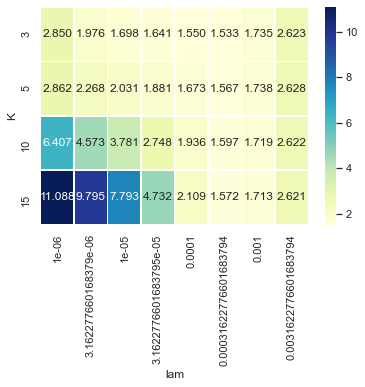

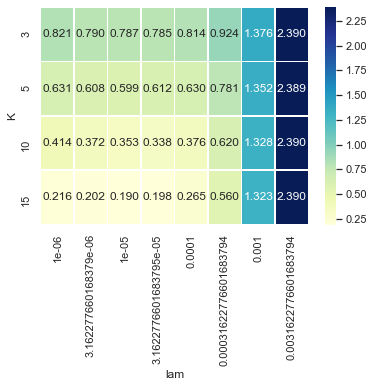

In [48]:
## LFM
# fit LFM_CV 
Ks, lams = [3,5,10,15], 10**np.arange(-6, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

After we find the best tuning parameters $(K^*,\lambda^*)$ = (3, 0.000316), we refit the model based on full training data and obtain the final estimator. Then we use the estimated model with the best tuning parameters to do prediction.

In [87]:
## refit the best model, and make prediction
print(shiing_cv.best_model)
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=10, lam=0.000316)
shiing.fit(train_pair, train_rating)
pred_ALS = shiing.predict(test_pair)

Fitting Reg-LFM: K: 10, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.000 RMSE: 6.989


Next, as stated before, we need to do some transformation on some predicted ratings in the test set. We add the ratings of users who only rate for one score back to the predicted ratings.

In [53]:
count=0
for i in range(len(test_pair)):
    for j in range(len(fixed_user)):
        if (test_pair[i,0]==fixed_user[j]):
            print('for index %d, change %.1f to %.1f' %(i, pred_ALS[i], fixed_rating[j]))
            pred_ALS[i] = fixed_rating[j]
            count=count+1
print(count)

# fit the rating less than 0 to 0 and fit the rating larger than 15 to 15
for i in range(len(pred_ALS)):
    if pred_ALS[i]<0:
        pred_ALS[i] = 0
    if pred_ALS[i]>15:
        pred_ALS[i] = 15

for index 43, change 0.0 to 15.0
for index 46, change 0.0 to 15.0
for index 51, change 0.0 to 15.0
for index 68, change 0.0 to 15.0
for index 138, change 0.0 to 15.0
for index 151, change 0.0 to 15.0
for index 155, change 0.0 to 15.0
for index 169, change 0.0 to 15.0
for index 183, change 0.0 to 15.0
for index 228, change 0.0 to 15.0
for index 236, change 0.0 to 15.0
for index 251, change 0.0 to 15.0
for index 261, change 2.4 to 7.0
for index 267, change 0.0 to 15.0
for index 293, change 0.6 to 1.0
for index 306, change 0.0 to 15.0
for index 342, change 0.0 to 15.0
for index 356, change 0.0 to 15.0
for index 378, change 0.0 to 15.0
for index 390, change 0.0 to 15.0
for index 403, change 0.0 to 15.0
for index 421, change 0.0 to 15.0
for index 426, change 0.0 to 15.0
for index 435, change 0.0 to 15.0
for index 476, change 0.0 to 15.0
for index 574, change 0.0 to 15.0
for index 577, change 0.0 to 15.0
for index 579, change 0.0 to 15.0
for index 582, change 0.0 to 15.0
for index 588, chang

In [54]:
# submission
sub['rating'] = pred_ALS
sub.to_csv('BaselineALS.csv', index=False)

The score in public leaderboard is 1.49204.

In this method, we simply use `LFM` to predict the ratings in test set. The assumption is that we include the interaction between user and item, while excluding the information for user or item. And this could be a possible reason that this method didn't perform well. Next, we would use `baseline method + LFM` to predict the rating, and estimate whether the following methods can improve the performance of rating prediction. 

## 3.3.Global+item+user mean LFM

Second, we implement a global + user average + item average + LFM based recommender system by LAS and ALS+GD algorithms

For ALS, ($𝐾,\lambda$)  are hyperparameters in this model, and we may find the best tuning parameters ($𝐾^∗,\lambda^∗$) by 𝑘-fold cross-validation.

According to notebook4.ipynb, we may use grid search based on cross-validation, and finding the best tuning parameters ($𝐾^∗,\lambda^∗$) that minimizes RMSE on validation set.

For ALS+GD, ($𝐾,\lambda, \alpha$) are hyperparameters, we use the same ($𝐾^∗,\lambda^∗$) as before. The learning rate $\alpha$ is chosen from large to small to make sure that rmse is decreasing.

### A. ALS algorithm :

We use 5-fold CV with  $\lambda$∈  10**np.arange(-6, -2, .5), and  $𝐾$∈{3,5,10,15}
(for k, we choose k=15 as boundary since we found that it will be overfitting if it larger than 15 in the test set)

5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.771, valid_rmse: 2.173
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.768, valid_rmse: 2.279
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.758, valid_rmse: 2.042
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.776, valid_rmse: 2.250
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.772, valid_rmse: 2.202
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.771, valid_rmse: 1.975
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.769, valid_rmse: 1.909
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.775, valid_rmse: 1.982
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.769, valid_rmse: 1.797
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.776, valid_rmse: 1.882
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.773, valid_rmse: 1.661
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.766, valid_rmse: 1.758
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.771, valid_rmse: 1.705
5-Fold CV for K: 3; lam: 0.00001: train_rmse: 0.769, valid_rmse: 1.788
5-Fold

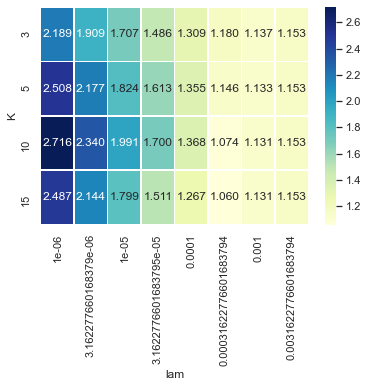

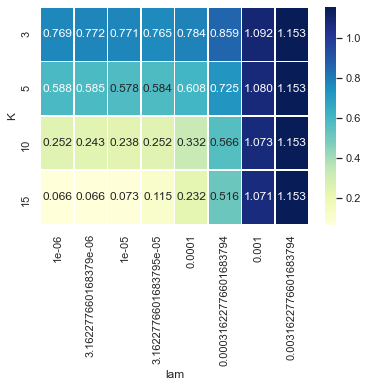

In [57]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_m = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)
# item_mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_m)
train_rating_res = train_rating_m - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)


# fit LFM_CV with residuals
Ks, lams = [3,5,10,15], 10**np.arange(-6, -2, .5)
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

Refit the model based on full training data and selected hyperparameters

The best $K$ and $\lambda$ that minimize rmse is $K$=15, $\lambda$=0.00032

In [59]:
## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing = LFM(n_user, n_item, K=best_K, lam= best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)

Fitting Reg-LFM: K: 15, lam: 0.00032
Reg-LFM: ite: 0; diff: 0.787 RMSE: 0.891
Reg-LFM: ite: 1; diff: 0.218 RMSE: 0.697
Reg-LFM: ite: 2; diff: 0.083 RMSE: 0.639
Reg-LFM: ite: 3; diff: 0.046 RMSE: 0.610
Reg-LFM: ite: 4; diff: 0.030 RMSE: 0.592
Reg-LFM: ite: 5; diff: 0.021 RMSE: 0.579
Reg-LFM: ite: 6; diff: 0.015 RMSE: 0.571
Reg-LFM: ite: 7; diff: 0.010 RMSE: 0.565
Reg-LFM: ite: 8; diff: 0.007 RMSE: 0.561
Reg-LFM: ite: 9; diff: 0.005 RMSE: 0.558
Reg-LFM: ite: 10; diff: 0.004 RMSE: 0.556
Reg-LFM: ite: 11; diff: 0.003 RMSE: 0.554
Reg-LFM: ite: 12; diff: 0.002 RMSE: 0.553
Reg-LFM: ite: 13; diff: 0.002 RMSE: 0.552
Reg-LFM: ite: 14; diff: 0.001 RMSE: 0.551
Reg-LFM: ite: 15; diff: 0.001 RMSE: 0.550
Reg-LFM: ite: 16; diff: 0.001 RMSE: 0.550
Reg-LFM: ite: 17; diff: 0.001 RMSE: 0.549
Reg-LFM: ite: 18; diff: 0.001 RMSE: 0.549
Reg-LFM: ite: 19; diff: 0.001 RMSE: 0.549
Reg-LFM: ite: 20; diff: 0.000 RMSE: 0.548
Reg-LFM: ite: 21; diff: 0.000 RMSE: 0.548
Reg-LFM: ite: 22; diff: 0.000 RMSE: 0.548
Reg-LFM

Add the ratings of users who only rate for one score back to the predicted ratings

In [60]:
count=0
for i in range(len(test_pair)):
    for j in range(len(fixed_user)):
        if (test_pair[i,0]==fixed_user[j]):
            print('for index %d, change %.1f to %.1f' %(i, pred[i], fixed_rating[j]))
            pred[i] = fixed_rating[j]
            count=count+1
print(count)

# fit the rating less than 0 to 0 and fit the rating larger than 15 to 15
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
    if pred[i]>15:
        pred[i] = 15

for index 43, change 7.8 to 15.0
for index 46, change 4.7 to 15.0
for index 51, change 6.4 to 15.0
for index 68, change 6.3 to 15.0
for index 138, change 4.3 to 15.0
for index 151, change 6.9 to 15.0
for index 155, change 6.4 to 15.0
for index 169, change 4.6 to 15.0
for index 183, change 5.6 to 15.0
for index 228, change 0.3 to 15.0
for index 236, change 6.1 to 15.0
for index 251, change 4.7 to 15.0
for index 261, change 5.5 to 7.0
for index 267, change 7.3 to 15.0
for index 293, change -0.6 to 1.0
for index 306, change 6.2 to 15.0
for index 342, change 7.6 to 15.0
for index 356, change 5.9 to 15.0
for index 378, change 4.8 to 15.0
for index 390, change 5.9 to 15.0
for index 403, change 6.2 to 15.0
for index 421, change 4.4 to 15.0
for index 426, change 6.2 to 15.0
for index 435, change 5.7 to 15.0
for index 476, change 5.4 to 15.0
for index 574, change 1.2 to 15.0
for index 577, change 7.3 to 15.0
for index 579, change 6.6 to 15.0
for index 582, change 6.1 to 15.0
for index 588, chan

The score in public leaderboard is 1.16236

In [62]:
# submission
sub = pd.read_csv('./sample_submission.csv')
sub['rating'] = pred
sub.to_csv('glbIU_ALS.csv', index=False)

### B: ALS + GD algorithm :

In [74]:
# LFM (ALS + GD)
class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is wrong in updating Q!')
                    ## Gradient
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    # r_{ui} - p_u^T q_i
                    err_tmp = rating_tmp - np.dot(self.P[user_id], self.Q[item_id])
                    # (r_{ui} - p_u^T q_i) p_u
                    sum_pu = sum_pu + err_tmp * self.P[user_id,:] / n_obs
                self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate * sum_pu - 2*learning_rate*lam*self.Q[item_id,:]
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    # r_{ui} - p_u^T q_i
                    err_tmp = rating_tmp - np.dot(self.P[user_id], self.Q[item_id])
                    # (r_{ui} - p_u^T q_i) q_i
                    sum_qi = sum_qi + err_tmp * self.Q[item_id,:] / n_obs
                self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*sum_qi - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - score_new + score_old
            print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [64]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)
# user_mean
train_rating_cm = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_m = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)
# item_mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_m)
train_rating_res = train_rating_m - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)
# fit correlation-based RS by residual ratings 
shiing = LFM(n_user, n_item, K=15, lam=0.00032)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=100.)

shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=50.)
pred = pred + shiing.predict(test_pair)

Fitting Reg-LFM: K: 15, lam: 0.00032
Reg-LFM: ite: 0; diff: 2.368 RMSE: 1.617
Reg-LFM: ite: 1; diff: 0.417 RMSE: 1.200
Reg-LFM: ite: 2; diff: 0.172 RMSE: 1.028
Reg-LFM: ite: 3; diff: 0.089 RMSE: 0.938
Reg-LFM: ite: 4; diff: 0.052 RMSE: 0.886
Reg-LFM: ite: 5; diff: 0.033 RMSE: 0.853
Reg-LFM: ite: 6; diff: 0.023 RMSE: 0.830
Reg-LFM: ite: 7; diff: 0.016 RMSE: 0.814
Reg-LFM: ite: 8; diff: 0.012 RMSE: 0.802
Reg-LFM: ite: 9; diff: 0.010 RMSE: 0.792
Reg-LFM: ite: 10; diff: 0.008 RMSE: 0.784
Reg-LFM: ite: 11; diff: 0.007 RMSE: 0.777
Reg-LFM: ite: 12; diff: 0.006 RMSE: 0.771
Reg-LFM: ite: 13; diff: 0.006 RMSE: 0.765
Reg-LFM: ite: 14; diff: 0.005 RMSE: 0.760
Reg-LFM: ite: 15; diff: 0.005 RMSE: 0.755
Reg-LFM: ite: 16; diff: 0.005 RMSE: 0.750
Reg-LFM: ite: 17; diff: 0.004 RMSE: 0.746
Reg-LFM: ite: 18; diff: 0.004 RMSE: 0.741
Reg-LFM: ite: 19; diff: 0.004 RMSE: 0.737
Reg-LFM: ite: 20; diff: 0.004 RMSE: 0.733
Reg-LFM: ite: 21; diff: 0.004 RMSE: 0.729
Reg-LFM: ite: 22; diff: 0.004 RMSE: 0.725
Reg-LFM

Add the ratings of users who only rate for one score back to the predicted ratings

In [65]:
count=0
for i in range(len(test_pair)):
    for j in range(len(fixed_user)):
        if (test_pair[i,0]==fixed_user[j]):
            print('for index %d, change %.1f to %.1f' %(i, pred[i], fixed_rating[j]))
            pred[i] = fixed_rating[j]
            count=count+1
print(count)

# fit the rating less than 0 to 0 and fit the rating larger than 15 to 15
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
    if pred[i]>15:
        pred[i] = 15

for index 43, change 7.8 to 15.0
for index 46, change 4.7 to 15.0
for index 51, change 6.4 to 15.0
for index 68, change 6.3 to 15.0
for index 138, change 4.3 to 15.0
for index 151, change 6.9 to 15.0
for index 155, change 6.4 to 15.0
for index 169, change 4.6 to 15.0
for index 183, change 5.6 to 15.0
for index 228, change 0.3 to 15.0
for index 236, change 6.1 to 15.0
for index 251, change 4.7 to 15.0
for index 261, change 5.5 to 7.0
for index 267, change 7.3 to 15.0
for index 293, change -0.6 to 1.0
for index 306, change 6.2 to 15.0
for index 342, change 7.6 to 15.0
for index 356, change 5.9 to 15.0
for index 378, change 4.8 to 15.0
for index 390, change 5.9 to 15.0
for index 403, change 6.2 to 15.0
for index 421, change 4.4 to 15.0
for index 426, change 6.2 to 15.0
for index 435, change 5.7 to 15.0
for index 476, change 5.4 to 15.0
for index 574, change 1.2 to 15.0
for index 577, change 7.3 to 15.0
for index 579, change 6.6 to 15.0
for index 582, change 6.1 to 15.0
for index 588, chan

The score in public leaderboard is 1.14746

In [66]:
# submission
sub = pd.read_csv('./sample_submission.csv')
sub['rating'] = pred
sub.to_csv('glbIU_ALS_GD.csv', index=False)

Further improvement: 

Since we have droped some users that rate 15, the global mean will be under estimated, which may cause bias in estimation. Also, when we include user average and item average, the global average information has already been contained. So we may think of only use item + user average LFM model to make prediction.

## 3.4.Final Model: Item+user_mean_LFM


Third, we implement a user average + item average + LFM based recommender system by LAS and ALS+GD algorithms

For ALS, ($𝐾,\lambda$)  are hyperparameters in this model, and we may find the best tuning parameters ($𝐾^∗,\lambda^∗$) by 𝑘-fold cross-validation. 

We have tried different hyperparameters' combination such as k is from 5 to 30, but we found that sometimes certain hyperparameters may behave good but not in the test dataset. After some consideration and validation, we decided use the k as c(3,5,10,15). Moreover, we use the ieration number as 50, so that it is the best result among all of the iteration numbers that we have tried. We hold the view that the more time you iterate the optimization process, we can get more precise result.

According to notebook4.ipynb, we may use grid search based on cross-validation, and finding the best tuning parameters ($𝐾^∗,\lambda^∗$) that minimizes RMSE on validation set.



### A. ALS algorithm :

We use 5-fold CV with  $\lambda$∈  10**np.arange(-6, -2, .5), and  $𝐾$∈{3,5,10,15} (for k, we choose k=15 as boundary since we found that it will be overfitting if it larger than 15 in the test set)

5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.762, valid_rmse: 1.972
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.782, valid_rmse: 2.204
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.775, valid_rmse: 2.238
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.781, valid_rmse: 2.216
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.768, valid_rmse: 2.345
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.766, valid_rmse: 2.113
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.773, valid_rmse: 2.135
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.773, valid_rmse: 2.377
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.766, valid_rmse: 2.186
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.779, valid_rmse: 1.922
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.759, valid_rmse: 2.066
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.760, valid_rmse: 1.862
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.783, valid_rmse: 1.955
5-Fold CV for K: 3; lam: 0.00000: train_rmse: 0.763, valid_rmse: 1.934
5-Fold

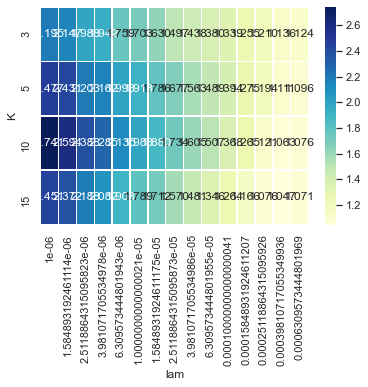

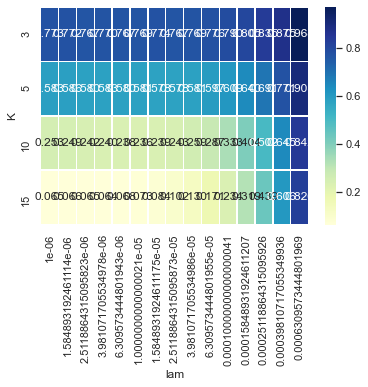

In [68]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = user_ave.predict(test_pair)
# item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)
# fit LFM RS by residual ratings
Ks, lams = [3,5,10,15], 10**np.arange(-6, -3, .2)
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid') 
shiing_cv.plot_grid('train')

In [70]:
## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred=pred

Fitting Reg-LFM: K: 15, lam: 0.00040
Reg-LFM: ite: 0; diff: 0.767 RMSE: 0.944
Reg-LFM: ite: 1; diff: 0.162 RMSE: 0.792
Reg-LFM: ite: 2; diff: 0.080 RMSE: 0.728
Reg-LFM: ite: 3; diff: 0.042 RMSE: 0.697
Reg-LFM: ite: 4; diff: 0.026 RMSE: 0.679
Reg-LFM: ite: 5; diff: 0.017 RMSE: 0.668
Reg-LFM: ite: 6; diff: 0.011 RMSE: 0.661
Reg-LFM: ite: 7; diff: 0.008 RMSE: 0.656
Reg-LFM: ite: 8; diff: 0.005 RMSE: 0.652
Reg-LFM: ite: 9; diff: 0.004 RMSE: 0.649
Reg-LFM: ite: 10; diff: 0.003 RMSE: 0.648
Reg-LFM: ite: 11; diff: 0.002 RMSE: 0.646
Reg-LFM: ite: 12; diff: 0.001 RMSE: 0.645
Reg-LFM: ite: 13; diff: 0.001 RMSE: 0.645
Reg-LFM: ite: 14; diff: 0.001 RMSE: 0.644
Reg-LFM: ite: 15; diff: 0.001 RMSE: 0.644
Reg-LFM: ite: 16; diff: 0.001 RMSE: 0.643
Reg-LFM: ite: 17; diff: 0.000 RMSE: 0.643
Reg-LFM: ite: 18; diff: 0.000 RMSE: 0.643
Reg-LFM: ite: 19; diff: 0.000 RMSE: 0.643
Reg-LFM: ite: 20; diff: 0.000 RMSE: 0.642
Reg-LFM: ite: 21; diff: 0.000 RMSE: 0.642
Reg-LFM: ite: 22; diff: 0.000 RMSE: 0.642
Reg-LFM

In [71]:
count=0
for i in range(len(test_pair)):
    for j in range(len(fixed_user)):
        if (test_pair[i,0]==fixed_user[j]):
            print('for index %d, change %.1f to %.1f' %(i, pred[i], fixed_rating[j]))
            pred[i] = fixed_rating[j]
            count=count+1
print(count)

# fit the rating less than 0 to 0 and fit the rating larger than 15 to 15
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
    if pred[i]>15:
        pred[i] = 15

for index 43, change 7.8 to 15.0
for index 46, change 4.7 to 15.0
for index 51, change 6.4 to 15.0
for index 68, change 6.3 to 15.0
for index 138, change 4.3 to 15.0
for index 151, change 6.9 to 15.0
for index 155, change 6.4 to 15.0
for index 169, change 4.6 to 15.0
for index 183, change 5.6 to 15.0
for index 228, change 0.3 to 15.0
for index 236, change 6.1 to 15.0
for index 251, change 4.7 to 15.0
for index 261, change 5.5 to 7.0
for index 267, change 7.3 to 15.0
for index 293, change -0.6 to 1.0
for index 306, change 6.2 to 15.0
for index 342, change 7.6 to 15.0
for index 356, change 5.9 to 15.0
for index 378, change 4.8 to 15.0
for index 390, change 5.9 to 15.0
for index 403, change 6.2 to 15.0
for index 421, change 4.4 to 15.0
for index 426, change 6.2 to 15.0
for index 435, change 5.7 to 15.0
for index 476, change 5.4 to 15.0
for index 574, change 1.2 to 15.0
for index 577, change 7.3 to 15.0
for index 579, change 6.6 to 15.0
for index 582, change 6.1 to 15.0
for index 588, chan

The score in public leaderboard is 1.11050

In [72]:
# submission
sub = pd.read_csv('./sample_submission.csv')
sub['rating'] = pred
sub.to_csv('Final-Best-Model.csv', index=False)

### B: ALS + GD algorithm :


For ALS+GD, ($𝐾,\lambda, \alpha$) are hyperparameters, we use the same ($𝐾^∗,\lambda^∗$) as before. The learning rate $\alpha$ is chosen from large to small to make sure that rmse is decreasing.


In [84]:
# LFM (ALS + GD)
class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=1000, tol=1e-4):
        self.P = np.random.randn(n_user, K)
        self.Q = np.random.randn(n_item, K)
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol

    def fit(self, train_pair, train_rating, learning_rate=0.0001):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is wrong in updating Q!')
                    ## Gradient
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    # r_{ui} - p_u^T q_i
                    err_tmp = rating_tmp - np.dot(self.P[user_id], self.Q[item_id])
                    # (r_{ui} - p_u^T q_i) p_u
                    sum_pu = sum_pu + err_tmp * self.P[user_id,:] / n_obs
                self.Q[item_id,:] = self.Q[item_id,:] + 2*learning_rate * sum_pu - 2*learning_rate*lam*self.Q[item_id,:]
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_qi, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    # r_{ui} - p_u^T q_i
                    err_tmp = rating_tmp - np.dot(self.P[user_id], self.Q[item_id])
                    # (r_{ui} - p_u^T q_i) q_i
                    sum_qi = sum_qi + err_tmp * self.Q[item_id,:] / n_obs
                self.P[user_id,:] = self.P[user_id,:] + 2*learning_rate*sum_qi - 2*learning_rate*lam*self.P[user_id,:]
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = - score_new + score_old
            print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if (diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [75]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = user_ave.predict(test_pair)
# item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)

# fit correlation-based RS by residual ratings,ratings k=20, lam=0.00032
shiing = LFM(n_user, n_item, K=15, lam=0.00032)
shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=100.)

#shiing.fit(train_pair=train_pair, train_rating=train_rating_res, learning_rate=50.)
pred = pred + shiing.predict(test_pair)


Fitting Reg-LFM: K: 15, lam: 0.00032
Reg-LFM: ite: 0; diff: 2.455 RMSE: 1.633
Reg-LFM: ite: 1; diff: 0.428 RMSE: 1.205
Reg-LFM: ite: 2; diff: 0.175 RMSE: 1.030
Reg-LFM: ite: 3; diff: 0.091 RMSE: 0.939
Reg-LFM: ite: 4; diff: 0.053 RMSE: 0.886
Reg-LFM: ite: 5; diff: 0.034 RMSE: 0.853
Reg-LFM: ite: 6; diff: 0.023 RMSE: 0.830
Reg-LFM: ite: 7; diff: 0.016 RMSE: 0.814
Reg-LFM: ite: 8; diff: 0.012 RMSE: 0.801
Reg-LFM: ite: 9; diff: 0.010 RMSE: 0.792
Reg-LFM: ite: 10; diff: 0.008 RMSE: 0.783
Reg-LFM: ite: 11; diff: 0.007 RMSE: 0.776
Reg-LFM: ite: 12; diff: 0.006 RMSE: 0.770
Reg-LFM: ite: 13; diff: 0.006 RMSE: 0.764
Reg-LFM: ite: 14; diff: 0.005 RMSE: 0.759
Reg-LFM: ite: 15; diff: 0.005 RMSE: 0.754
Reg-LFM: ite: 16; diff: 0.005 RMSE: 0.749
Reg-LFM: ite: 17; diff: 0.005 RMSE: 0.744
Reg-LFM: ite: 18; diff: 0.005 RMSE: 0.740
Reg-LFM: ite: 19; diff: 0.004 RMSE: 0.735
Reg-LFM: ite: 20; diff: 0.004 RMSE: 0.731
Reg-LFM: ite: 21; diff: 0.004 RMSE: 0.727
Reg-LFM: ite: 22; diff: 0.004 RMSE: 0.723
Reg-LFM

In [76]:
count=0
for i in range(len(test_pair)):
    for j in range(len(fixed_user)):
        if (test_pair[i,0]==fixed_user[j]):
            print('for index %d, change %.1f to %.1f' %(i, pred[i], fixed_rating[j]))
            pred[i] = fixed_rating[j]
            count=count+1
print(count)

# fit the rating less than 0 to 0 and fit the rating larger than 15 to 15
for i in range(len(pred)):
    if pred[i]<0:
        pred[i] = 0
    if pred[i]>15:
        pred[i] = 15

for index 43, change 7.8 to 15.0
for index 46, change 4.7 to 15.0
for index 51, change 6.4 to 15.0
for index 68, change 6.3 to 15.0
for index 138, change 4.3 to 15.0
for index 151, change 6.9 to 15.0
for index 155, change 6.4 to 15.0
for index 169, change 4.6 to 15.0
for index 183, change 5.6 to 15.0
for index 228, change 0.3 to 15.0
for index 236, change 6.1 to 15.0
for index 251, change 4.7 to 15.0
for index 261, change 5.5 to 7.0
for index 267, change 7.3 to 15.0
for index 293, change -0.5 to 1.0
for index 306, change 6.2 to 15.0
for index 342, change 7.6 to 15.0
for index 356, change 5.9 to 15.0
for index 378, change 4.8 to 15.0
for index 390, change 5.9 to 15.0
for index 403, change 6.2 to 15.0
for index 421, change 4.4 to 15.0
for index 426, change 6.2 to 15.0
for index 435, change 5.7 to 15.0
for index 476, change 5.4 to 15.0
for index 574, change 1.2 to 15.0
for index 577, change 7.3 to 15.0
for index 579, change 6.6 to 15.0
for index 582, change 6.1 to 15.0
for index 588, chan

In [77]:
# submission
sub = pd.read_csv('./sample_submission.csv')
sub['rating'] = pred
sub.to_csv('GD2.csv', index=False)

The score in public leaderboard is 1.12387

# 4.Result

The best model is Item + user_mean+ LFM model using LAS, here we print the result

### Print the user_id, item_id, and pred_rating, for the 289-th record in the test.csv.

In [78]:
# best submission
data = pd.read_csv('./dw2.csv')
pred=data['rating']


In [81]:
print('The 289th record of test pair is', test_pair[288])
print('The predicted rating. for 289th record is', pred[288])

The 289th record of test pair is [214 462]
The predicted rating. for 289th record is 1.784222774458165


### Print the user_id, item_id, and pred_rating, for the 360-th record in the test.csv.

In [82]:
print('The 360th record of test pair is', test_pair[359])
print('The predicted rating. for 360th record is', pred[359])

The 360th record of test pair is [264 907]
The predicted rating. for 360th record is 7.060481103609193


### Print the user_id, item_id, and pred_rating, for the 499-th record in the test.csv.

In [83]:
print('The 499th record of test pair is', test_pair[498])
print('The predicted rating. for 499th record is', pred[498])

The 499th record of test pair is [375 621]
The predicted rating. for 499th record is 8.752746241588605


## Print the top-5 preferred items based on our predicted_rating for the user_id in the above question

1155124499 ----- T1=499

1155124289 ----- T2=289

1155124360 ----- T3=360

In [85]:
# print the user_id, item_id and pred_rating
T1 = 499
T2 = 289
T3 = 360
print('The 3 user_ids are %d, %d, %d' %(test_pair[T1,0], test_pair[T2,0], test_pair[T3,0]))
print('The 3 item_ids are %d, %d, %d' %(test_pair[T1,1], test_pair[T2,1], test_pair[T3,1]))
print('The 3 pred_ratings are %d, %d, %d' %(pred[T1], pred[T2], pred[T3]))

The 3 user_ids are 336, 126, 42
The 3 item_ids are 120, 800, 518
The 3 pred_ratings are 4, 0, 5


In [86]:
# print the top-5 preferred items for the 336th, 126th, 42th users

user1 = test_pair[T1,0]
user2 = test_pair[T2,0]
user3 = test_pair[T3,0]
user=[user1, user2, user3]
index_user = [np.where(test_pair[:,0] == u)[0] for u in range(n_user)] 

for j in range(len(user)):
    user_j = user[j]
    user1_index = index_user[user_j]
    item1=[]
    rating1=[]
    for i in range(len(user1_index)):
        index = user1_index[i]
        item1.append(test_pair[index,1])
        rating1.append(pred[index])     
    s=np.argsort(rating1)[::-1]
    if len(s)>=5:
        print('The top-5 item for user %d is:' % user_j)
        for k in range(5):
            ind = s[k]
            print('Top %d: item %d, rating is %.3f' %(k+1, item1[ind], rating1[ind]))
    else:
        print('The user %d only rate for %d items' %(user_j, len(s)))
        for k in range(len(s)):
            ind = s[k]
            print('Top %d: item %d, rating is %.3f' %(k+1, item1[ind], rating1[ind]))
    print('\n')

The top-5 item for user 336 is:
Top 1: item 606, rating is 10.018
Top 2: item 767, rating is 7.826
Top 3: item 853, rating is 5.381
Top 4: item 751, rating is 4.943
Top 5: item 455, rating is 4.592


The top-5 item for user 126 is:
Top 1: item 925, rating is 7.822
Top 2: item 81, rating is 7.075
Top 3: item 698, rating is 7.035
Top 4: item 45, rating is 6.702
Top 5: item 430, rating is 5.490


The user 42 only rate for 4 items
Top 1: item 306, rating is 8.291
Top 2: item 178, rating is 7.950
Top 3: item 897, rating is 6.660
Top 4: item 518, rating is 5.923




# 5.Conclusion

In this project, we have tried many models which also include fit residual using KNN method and some other complex models, we found that the level of model complexity is not always in proportinal with the final precise result. Also we find it is interesting that tunning parameters is a very important work when we train the model, sometimes the best hyperparameters combination in the train dataset using cross-validation may not be the best hyperparameters in the test dataset.

We also found that the data contamination situation will make the model result unfair. We know that in machine learning, the problem of algorithmic bias is well known and well studied. Outcomes may be skewed by a range of factors and thus might be considered unfair to certain groups or individuals. 

For further improvement, during the process of EDA, we also found that the dataset exist the situation that the positive and negative samples are unbalanced, people prefer to rate lower scores (the distribution's mean is around 6 and the mode is 5). We come up with a solution that maybe we can set the tolerance be different in positive and negative samples.